In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import mixture
import itertools
from scipy import linalg

from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier

rand_state=42

-1    4849
 1    1001
Name: cleave, dtype: int64

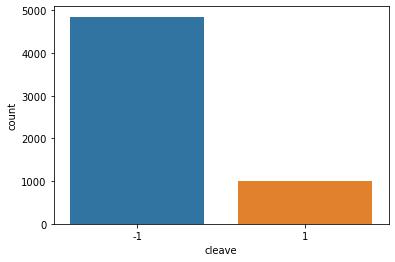

In [4]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)

In [5]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler()
x_train = scaling.fit_transform(x_train)
x_test = scaling.transform(x_test)

y_train_ori = y_train # for indexing later
enc = OneHotEncoder(categories='auto')
y_train = enc.fit_transform(y_train.values.reshape(-1, 1)).todense()
y_test = enc.transform(y_test.values.reshape(-1, 1)).todense()

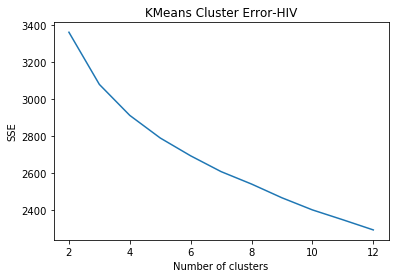

BEST GMM
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


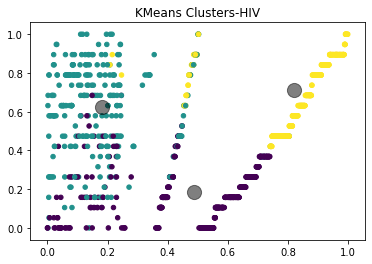

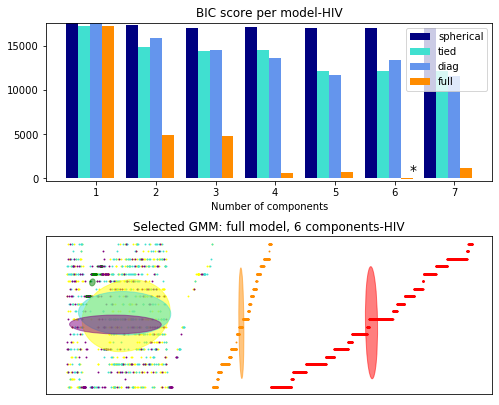

In [8]:
# KMeans, EM
kmeans_opt = kmeans()
opt_em = em()



In [6]:
# K-Means
# used https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
def kmeans():
    # EXP 1
    # How to choose the # of clusters
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    scores = {'sil': [], 'var': [], 'n_clusters': []}
    centers = {}

    sse = {}
    lowest_bic = np.infty
    bic = []
    for c in clusters:
        kmeans = KMeans(n_clusters=c, random_state=rand_state)
        kmeans.fit(x_train)
        center = kmeans.cluster_centers_
        centers[c] = center
        sse[c] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    

    # elbow
    #https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title('KMeans Cluster Error-HIV')
    plt.savefig('../images/' + 'elbow_KM_hiv.png')
    plt.show()
    
    
    # Visual inspection, 3 appears to be best.
    kmeans_opt = KMeans(n_clusters=3, random_state=rand_state)
    kmeans_opt.fit(x_train)
    y_kmeans_pred=kmeans_opt.predict(x_test)
    # from github above
    plt.title('KMeans Clusters-HIV')
    plt.scatter(x_test[:, 0], x_test[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
    centers = kmeans_opt.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.savefig('../images/' + 'KMeans_Clusters_hiv.png')
    
    # Might not correspond to labels, so testing prediction accuracy not necessarily valid
    return kmeans_opt
    


In [7]:
# Stolen from 
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

def em():
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 8)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    opt_em = None
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, random_state=42)
            gmm.fit(x_train)
            bic.append(gmm.bic(x_train))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    opt_em = best_gmm
    print('BEST GMM')
    print(opt_em)
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model-HIV')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    y_em_pred = opt_em.predict(x_train)
    # more colors for ellipses
    color_iter = itertools.cycle(['yellow', 'turquoise', 'green', 'red', 'purple',
                                  'darkorange'])
    for i, (mean, cov, color) in enumerate(zip(opt_em.means_, opt_em.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(y_em_pred == i):
            continue
        plt.scatter(x_train[y_em_pred == i, 0], x_train[y_em_pred == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mlp.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: ' + opt_em.covariance_type + ' model, ' + str(opt_em.n_components) +' components-HIV')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.savefig('../images/' + 'best_EM_hiv.png')
    plt.show()
    return opt_em
    

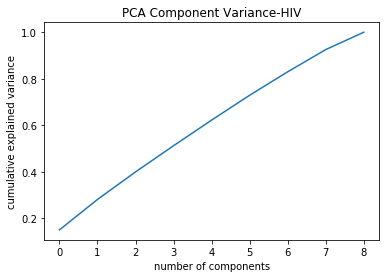

variance
[0.14968103 0.28067925 0.39920341 0.51187173 0.62203027 0.72900919
 0.82986867 0.92539303 1.        ]
LOSS
0.006613932504832572
LEARNED COMPONENTS
[[-0.63245099 -0.15926067  0.08311805  0.40088089  0.3957534   0.27574753
   0.18792144  0.24318432  0.28269623]
 [-0.31152364 -0.77196084  0.03688441 -0.01845117 -0.20641588 -0.35568372
  -0.18887178 -0.30258377 -0.09476636]
 [-0.06297209 -0.2816393  -0.23987631 -0.45916756 -0.24174125  0.20752491
   0.61514017  0.37284102 -0.17153733]
 [-0.08555949 -0.00315719 -0.80661876 -0.07852063  0.04127098 -0.08714498
  -0.44009109  0.27758356  0.23630478]
 [ 0.03288595  0.10845504 -0.162978    0.68829233 -0.40815759 -0.36271566
   0.23419979  0.2651677  -0.25204987]
 [-0.00632766 -0.00124452  0.37068098 -0.24750395  0.28983914 -0.53751373
  -0.15367158  0.62929316 -0.09350533]
 [-0.037224   -0.06347627  0.33049689  0.02864735 -0.58497365  0.43756537
  -0.44958697  0.36706644  0.11837408]
 [-0.01407931  0.11542151  0.101775   -0.11981751 -0.

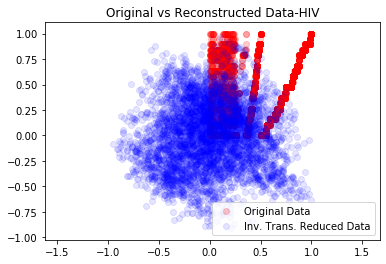

In [9]:
# PCA
#https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

# choosing number of components
pca = PCA(random_state=rand_state).fit(x_train)
x_pca = pca.transform(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Component Variance-HIV')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('../images/' + 'variance_PCA_hiv.png')
plt.show()

# so basically, to get 90% of the variance (info), I need to retain 8 components
print('variance')
print(np.cumsum(pca.explained_variance_ratio_))

# how well does it reconstruct data set?
pca_opt = PCA(n_components=8, random_state=rand_state).fit(x_train)
x_train_pca = pca_opt.transform(x_train)
X_projected = pca_opt.inverse_transform(x_train_pca)

plt.clf()
# perform the inverse transform of the reduced data and plot it along with the original data:
plt.title('Original vs Reconstructed Data-HIV')
plt1 = plt.scatter(x_train[:, 0], x_train[:, 1], color='red', alpha=0.2)
plt2 = plt.scatter(x_train_pca[:, 0],x_train_pca[:, 1], color='blue', alpha=0.1)
plt.legend((plt1, plt2), ('Original Data', 'Inv. Trans. Reduced Data'))
plt.axis('equal')
plt.savefig('../images/' + 'ori_recon_data_hiv.png')



loss = ((x_train - X_projected) ** 2).mean()
print("LOSS")
print(loss)
# learned components
print('LEARNED COMPONENTS')
print(pca_opt.components_)
# Explained variance
print('Explained Variance')
print(pca_opt.explained_variance_)

pca_opt = PCA(n_components=8, random_state=rand_state)

[0.3696841321332176, 0.4245192568898679, 0.5284122727887591, 0.5952667854321546, 0.6813955104852434, 0.7356383033999864, 1.0122606528517148, 1.1099031880822592]


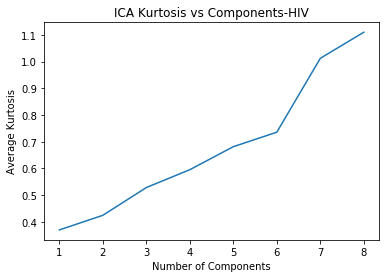

In [10]:
# ICA
# choosing number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8]
kurtosis = []
# based on description in https://piazza.com/class/k51r1vdohil5g3?cid=569
#Calculate the absolute value of kurtosis of each feature
#Take the mean of all these values, and use that as a score for the FastICA algorithm 
# with that number of components
# Pick the number of components that maximizes this score
for comp in comps:
    ica = FastICA(n_components=comp, random_state=rand_state).fit(x_train)
    x_train_ica = ica.transform(x_train)
    kurtosis.append(pd.DataFrame(x_train_ica).kurt().abs().mean())
print(kurtosis)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.title('ICA Kurtosis vs Components-HIV')
plt.plot(comps, kurtosis)
plt.savefig('../images/' + 'ICA_kurtosis_hiv.png')
# so no component reduction here. needs all of them?

# no reduction indicated
ica_opt = FastICA(n_components=8, random_state=rand_state)


[0.2420699718588731, 0.17326872983213606, 0.1256237540247853, 0.11623748693606649, 0.06982890471228333, 0.056288878970787735, 0.038727011273742826, 0.025769540036160596]


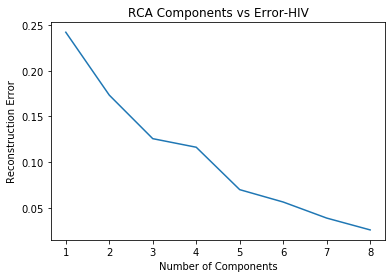

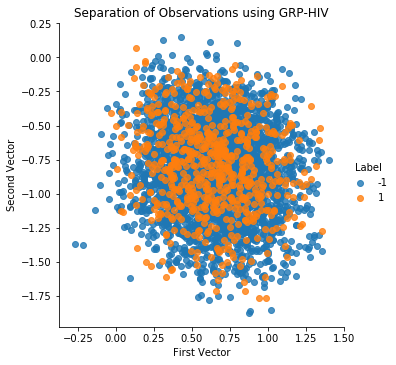

In [11]:
# RCA
# stole from https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html
# choosing number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8]
error = []
for comp in comps:
    GRP = GaussianRandomProjection(n_components=comp, random_state=rand_state)
    X_train_GRP = GRP.fit_transform(x_train)

    # reconstruction error
    # components
    components = GRP.components_
    # psuedo inverse
    inverse = linalg.pinv(components)
    # reconstructed data - take dot product
    ori_data = ((inverse @ components) @ (x_train.T)).T
    err = np.square(x_train - ori_data)
    av = np.nanmean(err)
    error.append(av)

print(error)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RCA Components vs Error-HIV')
plt.plot(comps, error)
plt.savefig('../images/' + 'RCA_error_hiv.png')
    
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=pd.DataFrame(x_train).index)

def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName + '-HIV')
    plt.savefig('../images/' + 'RCA_GRP_hiv.png', bbox_inches='tight')
scatterPlot(X_train_GRP, y_train_ori, "GRP")

# Reducing components to 7
rca_opt = GaussianRandomProjection(n_components=7, random_state=rand_state)


Feature ranking:
1. feature 0 (0.297592)
2. feature 4 (0.140553)
3. feature 3 (0.099334)
4. feature 6 (0.089468)
5. feature 5 (0.088386)
6. feature 2 (0.078021)
7. feature 8 (0.072248)
8. feature 7 (0.068705)
9. feature 1 (0.065694)
KEEP
[0, 4, 3, 6, 5, 2, 8, 7]
REMOVE
[1]


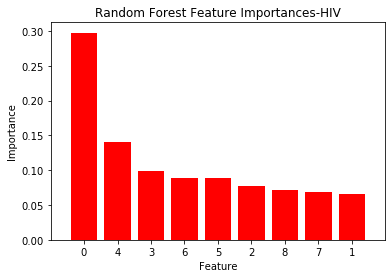

In [12]:
# My Choice-RandomForest
#https://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
clf = RandomForestClassifier(random_state=rand_state)
clf.fit(x_train, y_train)

#feat_import =  x_train[:,clf.feature_importances_.argsort()[::-1][:9]]
feat_import = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(feat_import)[::-1]

# Print the feature ranking
print("Feature ranking:")

feat_sum = 0
feat_kept_indices = []
feat_removed_indices = []
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], feat_import[indices[f]]))
    # just adding feature indices to a list until I hit at least 90% retention
    if feat_sum < .90:
        feat_sum += feat_import[indices[f]]
        feat_kept_indices.append(indices[f])
    else:
        feat_removed_indices.append(indices[f])
print('KEEP')
print(feat_kept_indices)
print('REMOVE')
print(feat_removed_indices)
# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest Feature Importances-HIV")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.bar(range(x_train.shape[1]), feat_import[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.savefig('../images/' + 'RF_feat_import_hiv.png')
plt.show()




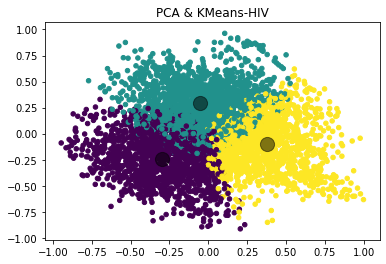

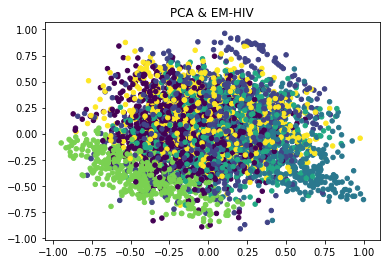

In [13]:
# PCA + KMeans - Run PCA first (above), then KMeans
# pca_opt 'optimal' from above
pca_opt.fit(x_train)
x_train_pca = pca_opt.transform(x_train)

# Visual inspection, 3 appears to be best.
kmeans_pca_opt = KMeans(n_clusters=3, random_state=rand_state)
kmeans_pca_opt.fit(x_train_pca)
y_kmeans_pred=kmeans_pca_opt.predict(x_train_pca)

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_pca_opt.cluster_centers_
plt.title('PCA & KMeans-HIV')

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.savefig('../images/' + 'pca_kmeans_hiv.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# PCA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_pca)
y_em_pred=opt_em.predict(x_train_pca)

plt.title("PCA & EM-HIV")
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'pca_em_hiv.png')



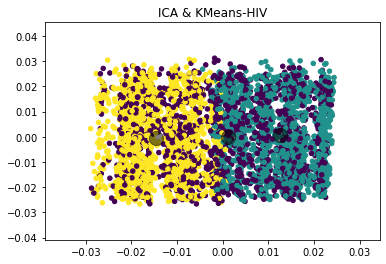

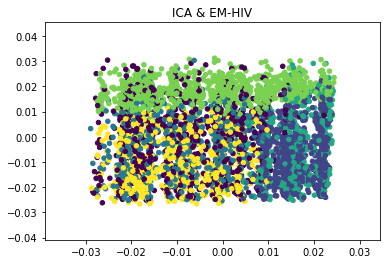

In [14]:
# ICA + KMeans - Run ICA first, then KMeans
# ica_opt 'optimal' from above
# ICA + EM

ica_opt.fit(x_train)
x_train_ica = ica_opt.transform(x_train)

# Visual inspection, 3 appears to be best.
kmeans_ica_opt = KMeans(n_clusters=3, random_state=rand_state)
kmeans_ica_opt.fit(x_train_ica)
y_kmeans_pred=kmeans_ica_opt.predict(x_train_ica)

plt.scatter(x_train_ica[:, 0], x_train_ica[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_ica_opt.cluster_centers_
plt.title('ICA & KMeans-HIV')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'ica_kmeans_hiv.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# ICA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_ica)
y_em_pred=opt_em.predict(x_train_ica)

plt.title("ICA & EM-HIV")
plt.scatter(x_train_ica[:, 0], x_train_ica[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'ica_em_hiv.png')

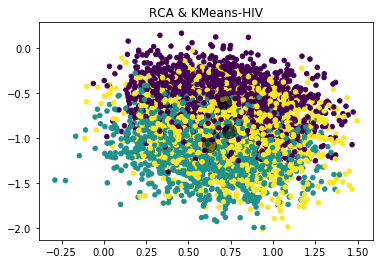

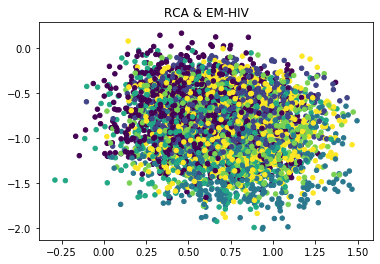

In [15]:
# RCA + KMeans - Run RCA first, then KMeans
#rca_opt 'optimal' from above
# RCA + EM
rca_opt.fit(x_train)
x_train_rca = rca_opt.transform(x_train)

# Visual inspection, 3 appears to be best.
kmeans_rca_opt = KMeans(n_clusters=3, random_state=rand_state)
kmeans_rca_opt.fit(x_train_rca)
y_kmeans_pred=kmeans_rca_opt.predict(x_train_rca)

plt.scatter(x_train_rca[:, 0], x_train_rca[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_rca_opt.cluster_centers_
plt.title('RCA & KMeans-HIV')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'rca_kmeans_hiv.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# RCA + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_rca)
y_em_pred=opt_em.predict(x_train_rca)

plt.title("RCA & EM-HIV")
plt.scatter(x_train_rca[:, 0], x_train_rca[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'rca_em_hiv.png')

[[0.48474731 0.84210526 0.84210526 ... 0.68421053 0.78947368 0.84210526]
 [0.21748368 0.10526316 0.42105263 ... 0.         0.26315789 0.36842105]
 [0.98315374 0.89473684 0.89473684 ... 0.89473684 0.10526316 0.78947368]
 ...
 [0.27029898 0.21052632 0.31578947 ... 0.47368421 0.89473684 0.42105263]
 [0.49461223 0.89473684 0.57894737 ... 0.36842105 0.         0.68421053]
 [0.51373501 0.         0.15789474 ... 1.         0.15789474 0.26315789]]
(4680, 9)
[[0.48474731 0.84210526 0.         ... 0.68421053 0.78947368 0.84210526]
 [0.21748368 0.42105263 0.47368421 ... 0.         0.26315789 0.36842105]
 [0.98315374 0.89473684 0.36842105 ... 0.89473684 0.10526316 0.78947368]
 ...
 [0.27029898 0.31578947 0.89473684 ... 0.47368421 0.89473684 0.42105263]
 [0.49461223 0.57894737 0.68421053 ... 0.36842105 0.         0.68421053]
 [0.51373501 0.15789474 0.         ... 1.         0.15789474 0.26315789]]
(4680, 8)


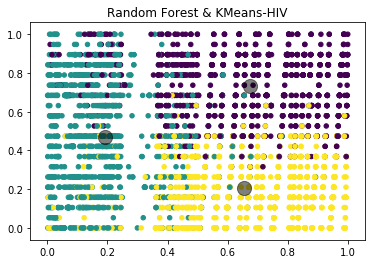

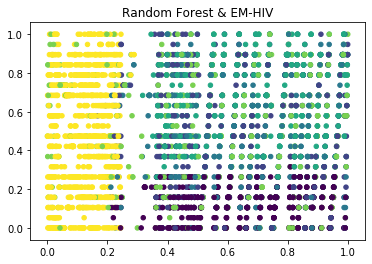

In [16]:
# RandomForest + KMeans - Run RandomForest First, then KMeans
# feat_kept_indices represents the indices kept by RF.
# feat_removed_indices represents features discarded by RF
# RandomForest + EM
#feat_kept_indices = sorted(feat_kept_indices)
feat_removed_indices = sorted(feat_removed_indices)
print(x_train)
print(x_train.shape)

x_train_rfc = np.delete(x_train, obj=feat_removed_indices, axis=1)
print(x_train_rfc)
print(x_train_rfc.shape)

# Visual inspection, 3 appears to be best.
kmeans_rfc_opt = KMeans(n_clusters=3, random_state=rand_state)
kmeans_rfc_opt.fit(x_train_rfc)
y_kmeans_pred=kmeans_rfc_opt.predict(x_train_rfc)

plt.scatter(x_train_rfc[:, 0], x_train_rfc[:, 1], s=20, c=y_kmeans_pred, cmap='viridis')
centers = kmeans_rfc_opt.cluster_centers_
plt.title('Random Forest & KMeans-HIV')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.savefig('../images/' + 'rfc_kmeans_hiv.png')
plt.show()
# Might not correspond to labels, so testing prediction accuracy not necessarily valid

plt.clf()
# RFC + EM
# opt_em 'optimal' from above
opt_em.fit(x_train_rfc)
y_em_pred=opt_em.predict(x_train_rfc)

plt.title("Random Forest & EM-HIV")
plt.scatter(x_train_rfc[:, 0], x_train_rfc[:, 1], s=20, c=y_em_pred, cmap='viridis')
plt.savefig('../images/' + 'rfc_em_hiv.png')